In [ ]:
# !pip install matplotlib

11180


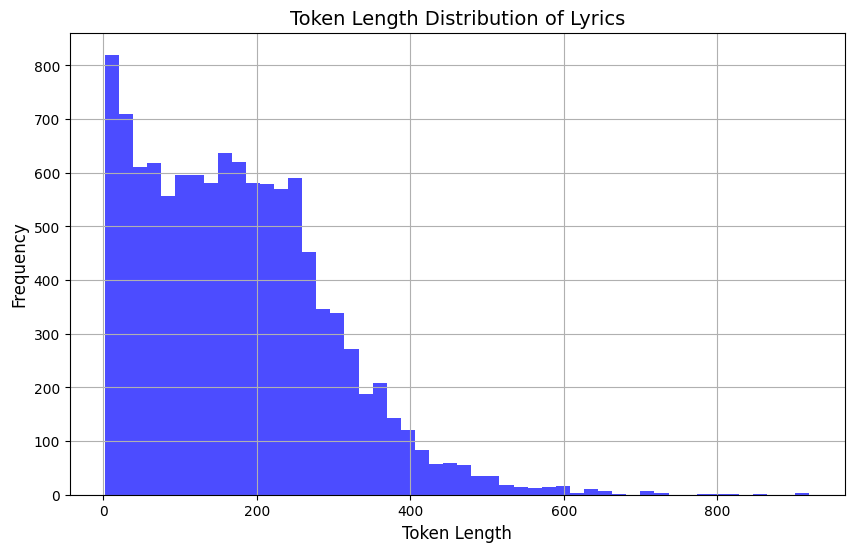

count    11180.000000
mean       175.366369
std        121.056405
min          2.000000
25%         77.000000
50%        164.000000
75%        250.000000
max        920.000000
Name: tokenized_length, dtype: float64

In [8]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from pathlib import Path

lyrics_data = pd.read_csv('data/lyrics_midi_data.csv')
print(len(lyrics_data))
# Initialize the GPT-2 tokenizer
lyrics_tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Tokenize the lyrics and calculate token lengths
lyrics_data['tokenized_length'] = lyrics_data['lyrics'].apply(
    lambda x: len(lyrics_tokenizer.tokenize(x))
)

# Analyze tokenized lengths
token_length_stats = lyrics_data['tokenized_length'].describe()

plt.figure(figsize=(10, 6))
plt.hist(lyrics_data['tokenized_length'], bins=50, color='blue', alpha=0.7)
plt.title('Token Length Distribution of Lyrics', fontsize=14)
plt.xlabel('Token Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

token_length_stats


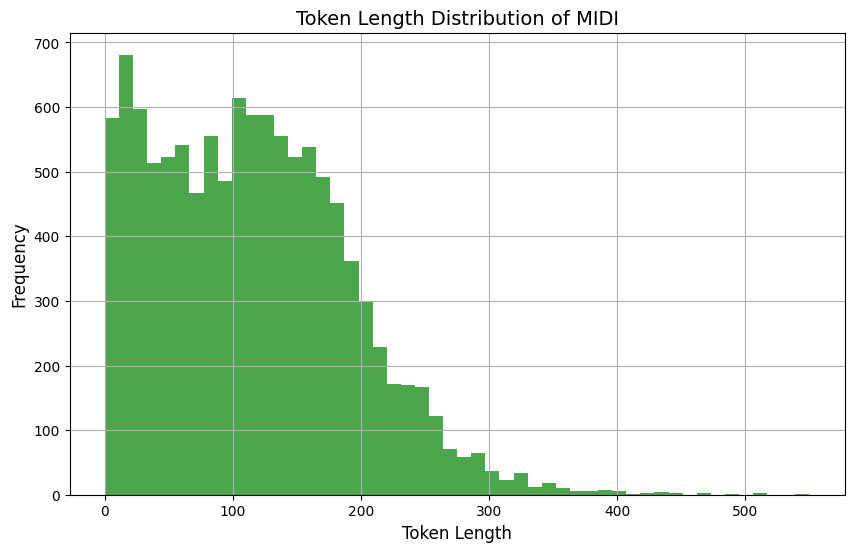

count    11180.000000
mean       114.953936
std         75.629433
min          0.000000
25%         52.000000
50%        110.000000
75%        166.000000
max        550.000000
Name: midi_tokenized_length, dtype: float64


In [9]:
import matplotlib.pyplot as plt
from src.utils import initialize_midi_tokenizer
from symusic import Score

midi_tokenizer = initialize_midi_tokenizer()

# Tokenize MIDI sequences and calculate token lengths
def get_midi_token_length(midi_path):
    try:
        midi_score = Score(midi_path)
        tokenized = midi_tokenizer.encode(midi_score)[0].ids
        return len(tokenized)
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return 0
root_dir = "data"
lyrics_data['midi_path'] = lyrics_data['midi_path'].apply(lambda x: os.path.join(root_dir, x))

lyrics_data['midi_tokenized_length'] = lyrics_data['midi_path'].apply(get_midi_token_length)

# Analyze tokenized lengths
midi_length_stats = lyrics_data['midi_tokenized_length'].describe()

plt.figure(figsize=(10, 6))
plt.hist(lyrics_data['midi_tokenized_length'], bins=50, color='green', alpha=0.7)
plt.title('Token Length Distribution of MIDI', fontsize=14)
plt.xlabel('Token Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

print(midi_length_stats)

In [10]:
filtered_lyrics_data = lyrics_data[lyrics_data['midi_tokenized_length'] > 10]  # Adjust threshold as needed

In [11]:
filtered_lyrics_data

,lyrics,midi_path,tokenized_length,midi_tokenized_length
0,In sleep he sang to me\nin dreams he came\ntha...,data/lmd-full_and_reddit_MIDI_dataset/sentence...,107,66
1,I have plans and schemes\nAnd I have hopes and...,data/lmd-full_and_reddit_MIDI_dataset/sentence...,82,66
2,I get up and nothing gets me You got\nit tough...,data/lmd-full_and_reddit_MIDI_dataset/sentence...,48,29
3,Man a hot like seven inches\nfrom the midday I...,data/lmd-full_and_reddit_MIDI_dataset/sentence...,381,247
4,We come from the land of the ice and snow\nfro...,data/lmd-full_and_reddit_MIDI_dataset/sentence...,177,101
...,...,...,...,...
11175,Remember when you were young\nhow the hero was...,data/lmd-full_and_reddit_MIDI_dataset/sentence...,134,135
11176,Girl tell me only that I have heart for\nand y...,data/lmd-full_and_reddit_MIDI_dataset/sentence...,53,48
11177,Yo tell you what I want\nWhat I really really ...,data/lmd-full_and_reddit_MIDI_dataset/sentence...,525,287
11178,Been around the world I\nI I I find my baby\nI...,data/lmd-full_and_reddit_MIDI_dataset/sentence...,93,62


In [12]:
# Check for exact duplicates
duplicates = lyrics_data.duplicated(subset=['lyrics', 'midi_path']).sum()
print(f"Number of exact duplicates: {duplicates}")

# # Remove duplicates if necessary
# lyrics_data = lyrics_data.drop_duplicates(subset=['lyrics', 'midi_path']).reset_index(drop=True)

Number of exact duplicates: 0


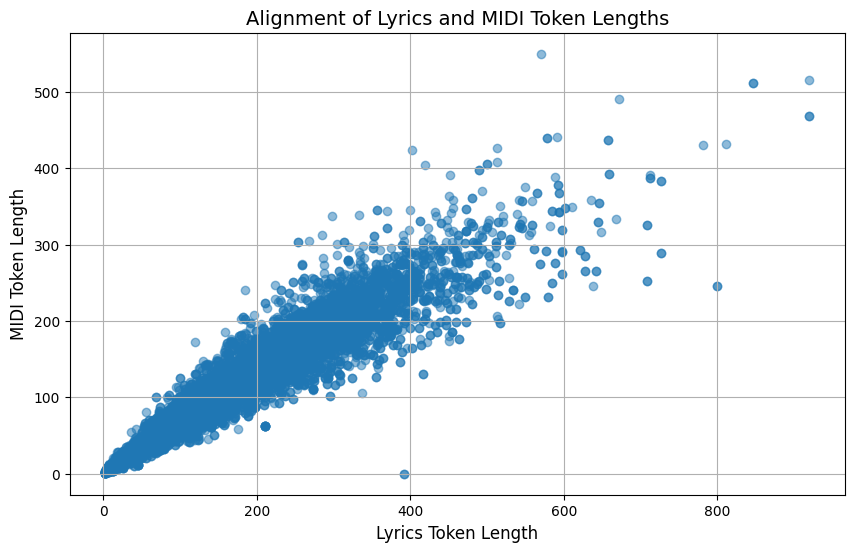

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(lyrics_data['tokenized_length'], lyrics_data['midi_tokenized_length'], alpha=0.5)
plt.title("Alignment of Lyrics and MIDI Token Lengths", fontsize=14)
plt.xlabel("Lyrics Token Length", fontsize=12)
plt.ylabel("MIDI Token Length", fontsize=12)
plt.grid(True)
plt.show()


In [14]:
# Identify outliers (e.g., sequences longer than max length or shorter than a threshold)
lyrics_outliers = lyrics_data[lyrics_data['tokenized_length'] > 512]
midi_outliers = lyrics_data[lyrics_data['midi_tokenized_length'] > 512]

print(f"Lyrics outliers (length > 512): {len(lyrics_outliers)}")
print(f"MIDI outliers (length > 512): {len(midi_outliers)}")

# # remove outliers
# lyrics_data = lyrics_data[
#     (lyrics_data['lyrics_tokenized_length'] <= 512) &
#     (lyrics_data['midi_tokenized_length'] <= 512)
# ]


Lyrics outliers (length > 512): 129
MIDI outliers (length > 512): 2


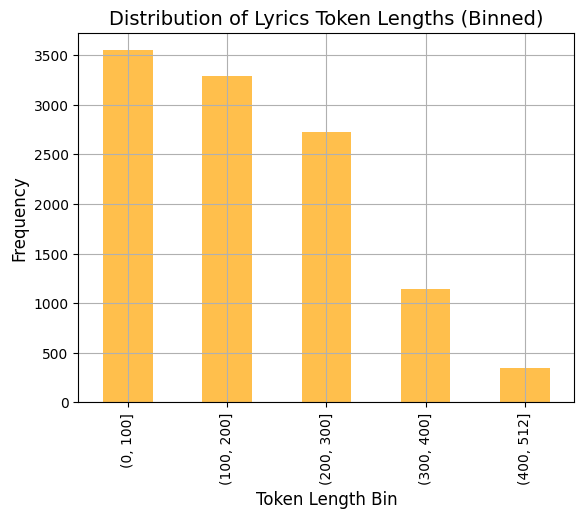

In [15]:
# Group by length bins
lyrics_data['lyrics_length_bin'] = pd.cut(lyrics_data['tokenized_length'], bins=[0, 100, 200, 300, 400, 512])
length_distribution = lyrics_data['lyrics_length_bin'].value_counts()

# Plot the distribution
length_distribution.plot(kind='bar', color='orange', alpha=0.7)
plt.title("Distribution of Lyrics Token Lengths (Binned)", fontsize=14)
plt.xlabel("Token Length Bin", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()


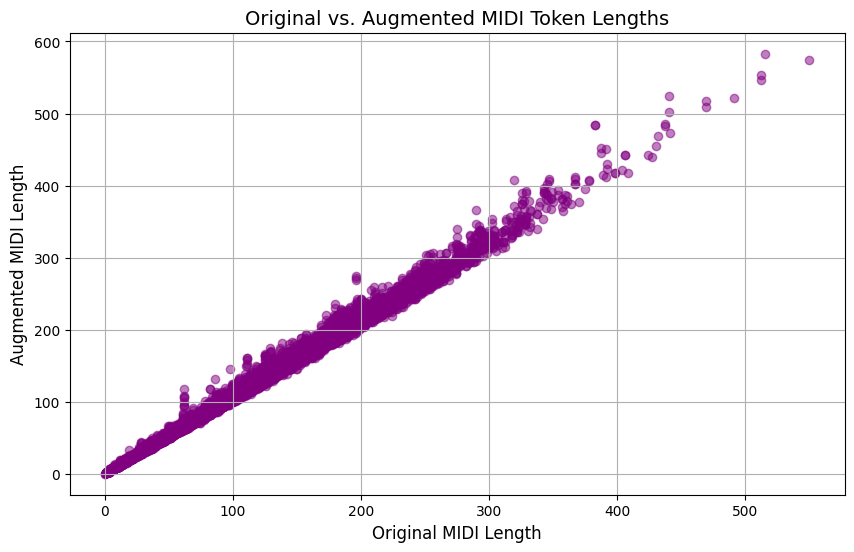

In [16]:
# Tokenize augmented MIDI
from src.data import randomize_midi_pitch
lyrics_data['augmented_midi_length'] = lyrics_data['midi_path'].apply(
    lambda path: len(midi_tokenizer.encode(randomize_midi_pitch(Score(path)))[0].ids)
)

# Compare original and augmented lengths
plt.figure(figsize=(10, 6))
plt.scatter(lyrics_data['midi_tokenized_length'], lyrics_data['augmented_midi_length'], alpha=0.5, color='purple')
plt.title("Original vs. Augmented MIDI Token Lengths", fontsize=14)
plt.xlabel("Original MIDI Length", fontsize=12)
plt.ylabel("Augmented MIDI Length", fontsize=12)
plt.grid(True)
plt.show()

In [17]:
# Tokenize all lyrics and collect unique tokens
lyrics_vocab = set()
lyrics_data['lyrics'].apply(lambda x: lyrics_vocab.update(lyrics_tokenizer.tokenize(x)))
print(f"Lyrics Vocabulary Size: {len(lyrics_vocab)}")

# Analyze token frequencies
from collections import Counter
all_tokens = []
lyrics_data['lyrics'].apply(lambda x: all_tokens.extend(lyrics_tokenizer.tokenize(x)))
token_counts = Counter(all_tokens)

print(f"Most Common Tokens: {token_counts.most_common(10)}")
print(f"Least Common Tokens: {token_counts.most_common()[:-11:-1]}")


Lyrics Vocabulary Size: 17192
Most Common Tokens: [('Ċ', 336706), ('Ġthe', 49658), ('Ġyou', 46282), ('ĠI', 37004), ('Ġto', 32254), ('Ġme', 27461), ('Ġa', 27344), ('I', 26530), ('Ġmy', 19357), ('Ġin', 16748)]
Least Common Tokens: [('ĠAudrey', 1), ('ĠMC', 1), ('Ġlac', 1), ('ĠFriendship', 1), ('NOR', 1), ('ATOR', 1), ('ANI', 1), ('REL', 1), ('ĠCOP', 1), ('PI', 1)]


In [18]:
# Tokenize all MIDI sequences and collect unique tokens
midi_vocab = set()
lyrics_data['midi_path'].apply(lambda path: midi_vocab.update(midi_tokenizer.encode(Score(path))[0].ids))
print(f"MIDI Vocabulary Size: {len(midi_vocab)}")

# Analyze MIDI token frequencies
all_midi_tokens = []
lyrics_data['midi_path'].apply(lambda path: all_midi_tokens.extend(midi_tokenizer.encode(Score(path))[0].ids))
midi_token_counts = Counter(all_midi_tokens)

print(f"Most Common MIDI Tokens: {midi_token_counts.most_common(10)}")
print(f"Least Common MIDI Tokens: {midi_token_counts.most_common()[:-11:-1]}")

MIDI Vocabulary Size: 29851
Most Common MIDI Tokens: [(224, 9833), (254, 5387), (167, 4240), (182, 4050), (187, 3978), (156, 3817), (189, 3690), (152, 3664), (204, 3626), (169, 3597)]
Least Common MIDI Tokens: [(16486, 1), (22329, 1), (22670, 1), (23948, 1), (17205, 1), (22533, 1), (22535, 1), (121, 1), (120, 1), (114, 1)]
